In [1]:
import numpy as np
import pandas as pd
import re
import string

#NLTK library
import nltk
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

#for graphs
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from wordcloud import WordCloud

#model training
import tensorflow as tf
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix,classification_report
from sklearn.metrics import f1_score, roc_auc_score
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Masking, Dropout
from tensorflow.keras import Sequential, Input, optimizers
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.ensemble import RandomForestClassifier

In [2]:
#importing the data in form of csv
df_train = pd.read_csv('/Users/pranj/Desktop/Assignments/Machine_learning/Project/train.csv')
df_test = pd.read_csv('/Users/pranj/Desktop/Assignments/Machine_learning/Project/test.csv')

In [3]:
df_train.head(5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_test.head(5)

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


C:\Users\pranj\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


Text(0, 0.5, 'samples')

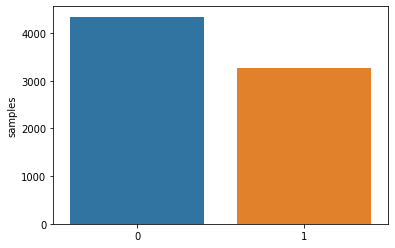

In [6]:
x=df_train.target.value_counts()
sns.barplot(x.index,x)
plt.gca().set_ylabel('samples')

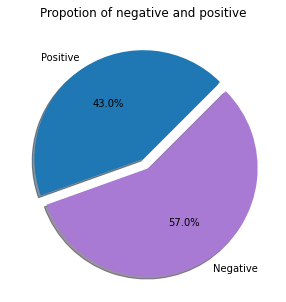

In [7]:
X = df_train.text
y = df_train.target

fig = plt.figure(figsize=(5,5))
colors=["#1F77B4",'#A87AD4']
pos=y[y == 1]
neg=y[y == 0]
ck=[pos.count(),neg.count()]
legpie=plt.pie(ck,labels=["Positive","Negative"],
                 autopct ='%1.1f%%', 
                 shadow = True,
                 colors = colors,
                 startangle = 45,
                 explode=(0, 0.1))
plt.title("Propotion of negative and positive")
plt.show()

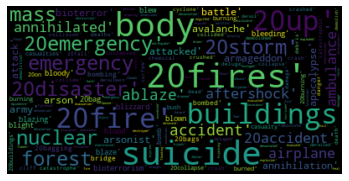

In [8]:
#Word cloud of the keywords
keyword_words = str(df_train['keyword'].dropna().unique().tolist())

keyword_wordcloud = WordCloud(
    background_color='black',
    stopwords=None,
    max_words=200,
    max_font_size=40, 
    random_state=42
).generate(keyword_words)

plt.imshow(keyword_wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [9]:
# turn hashtags to normal words
def re_encode_hashtags(input_string):
    return None if pd.isna(input_string) else input_string.replace('#', '')


# remove URLs from the tweets
def remove_links(input_string):
    res = input_string
    urls = re.findall(r'(https?://[^\s]+)', res) #remove https
    for link in urls:
        res = res.strip(link)
    return res

In [10]:
df_train['text'] = df_train['text'].map(re_encode_hashtags)
df_train['text'] = df_train['text'].map(remove_links)
df_test['text'] = df_test['text'].map(re_encode_hashtags)
df_test['text'] = df_test['text'].map(remove_links)

In [11]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1


In [12]:
stop_words = set(stopwords.words("english"))

In [13]:
#tokenization
tokenizer = TweetTokenizer(
    preserve_case=False,
    reduce_len=True,
    strip_handles=True,
)

def tokenize_tweets(tokenizer, input_text):
    tokens = list(tokenizer.tokenize(input_text))
    tokens = [re.sub('[^A-Za-z0-9]+', '', i) for i in tokens]
    tokens = [t for t in tokens if t not in stop_words] #removing stop words
    return tokens

df_train['tokens'] = df_train['text']
df_train['tokens'] = df_train['tokens'].apply(lambda x: tokenize_tweets(tokenizer, x))

df_test['tokens'] = df_test['text'].apply(lambda x: tokenize_tweets(tokenizer, x))

In [14]:
df_train.head()

,id,keyword,location,text,target,tokens
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,"[deeds, reason, earthquake, may, allah, forgiv..."
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, , canada]"
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, , shelter, place, , notifie..."
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,"[13000, people, receive, wildfires, evacuation..."
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi..."


In [15]:
df_test.head()

,id,keyword,location,text,tokens
0,0,NaN,NaN,Just happened a terrible car crash,"[happened, terrible, car, crash]"
1,2,NaN,NaN,"Heard about earthquake is different cities, st...","[heard, earthquake, different, cities, , stay,..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...","[forest, fire, spot, pond, , geese, fleeing, a..."
3,9,NaN,NaN,Apocalypse lighting. Spokane wildfires,"[apocalypse, lighting, , spokane, wildfires]"
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, 28, china, taiwan]"


In [16]:
df_train['text_token'] = [' '.join(map(str, l)) for l in df_train['tokens']]
df_test['text_token'] = [' '.join(map(str, l)) for l in df_test['tokens']]
df_train['text_token']=df_train['text_token'].str.replace("im","")
df_test['text_token']=df_test['text_token'].str.replace("im","")
df_train.head()

,id,keyword,location,text,target,tokens,text_token
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,"[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, , canada]",forest fire near la ronge sask canada
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, , shelter, place, , notifie...",residents asked shelter place notified offic...
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,"[13000, people, receive, wildfires, evacuation...",13000 people receive wildfires evacuation orde...
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfires pou...


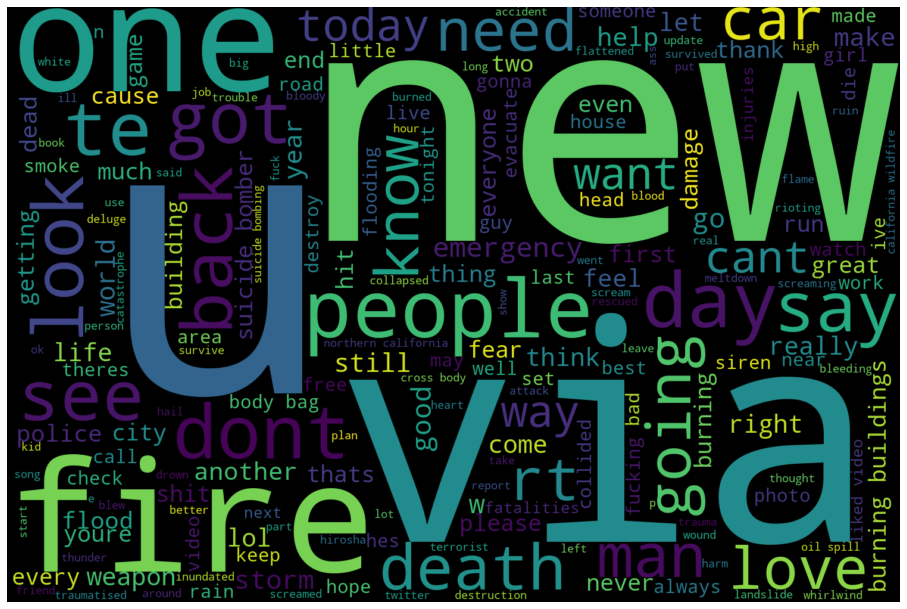

In [17]:
plt.figure(figsize=(16,12))
wordcloud = WordCloud(background_color="black",max_words=200, width=1500, height=1000).generate(' '.join(df_train['text_token']))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

# Count Vector and Random Forest

In [27]:
X = df_train["text_token"]
y = df_train["target"]

In [28]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30,random_state= 42)

In [30]:
vt = CountVectorizer(analyzer="word")
X_train_count = vt.fit_transform(X_train)
X_test_count = vt.transform(X_test)

In [31]:
print(X_train_count.toarray())
X_train_count

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


<5329x13363 sparse matrix of type '<class 'numpy.int64'>'
	with 47098 stored elements in Compressed Sparse Row format>

In [35]:
rf_params = {"max_depth": [2,4,6,10,12],
            "max_features": [2,5,7],
            "n_estimators":[12,15,16,]}
rf = RandomForestClassifier()

In [36]:
rf_model_cv = GridSearchCV(rf,rf_params,cv = 5,n_jobs = -1)

In [37]:
rf_model_cv.fit(X_train_count,y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [2, 4, 6, 10, 12],
                         'max_features': [2, 5, 7],
                         'n_estimators': [12, 15, 16]})

In [38]:
rf_model_cv.best_params_

{'max_depth': 12, 'max_features': 7, 'n_estimators': 15}

In [39]:
rf_tuned = RandomForestClassifier(max_depth = 12,
                                 max_features = 7,
                                 min_samples_split = 2).fit(X_train_count,y_train)

In [40]:
rf_pred = rf_tuned.predict(X_test_count)
rf_train_pred = rf_tuned.predict(X_train_count)

In [44]:
print("X Test")
print(classification_report(y_test,rf_pred))
print("X Train")
print(classification_report(y_train,rf_train_pred))

X Test
              precision    recall  f1-score   support

           0       0.58      1.00      0.73      1318
           1       0.00      0.00      0.00       966

    accuracy                           0.58      2284
   macro avg       0.29      0.50      0.37      2284
weighted avg       0.33      0.58      0.42      2284

X Train
              precision    recall  f1-score   support

           0       0.57      1.00      0.72      3024
           1       0.00      0.00      0.00      2305

    accuracy                           0.57      5329
   macro avg       0.28      0.50      0.36      5329
weighted avg       0.32      0.57      0.41      5329



C:\Users\pranj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pranj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pranj\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\pranj\anaconda3\lib\site-packages\sklearn\metr

# LSTM

Referance: https://keras.io/examples/nlp/bidirectional_lstm_imdb/

In [46]:
X = df_train["text"]
y = df_train["target"]

In [47]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30,random_state= 42)

In [49]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Creates and fits a TensorFlow Tokenizer
tokenizer = Tokenizer(num_words=10_000, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)

#Creates sequences of numeric representations of words
training_sequences = tokenizer.texts_to_sequences(X_train)
#pads sequences so they all have the same length
training_sequences = pad_sequences(training_sequences, maxlen=20)

#Process test data in the same way for later evaluation
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_sequences = pad_sequences(testing_sequences, maxlen=20)

for i in range(5):
    print(training_sequences[i], '\n')

[   0    0    0 2736  137 3603  180   20 1221  546 1344  870    4  614
 1482 3604   38  916   13  917] 

[   0    0    0    0    0    0    0  199 2215 3605  979 5437  504    5
 5438  274 5439 5440 5441 5442] 

[   0    0    0    0    0    0    0    0    0    0    0  814 1905  249
 1126  584  647  124   21   85] 

[  0   0   0   0  84 342   4   3 815   6 615 547 288   9  26   5  25  32
  13 918] 

[   4    2 2737  203    9 5443   38   22  871  227  771  261 2738  418
   14  547 3607   10  200 1906] 



In [50]:
from tensorflow.keras.callbacks import Callback

class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') > 0.95:
            print("Accuracy over 95%... Stopping training")
            self.model.stop_training = True

my_callback = CustomCallback()

In [51]:
from tensorflow.keras.callbacks import LearningRateScheduler

#creates a function that updates the learning rate based on the epoch number
def scheduler(epoch, lr):
    if epoch < 2:
        return 0.01
    else:
        return lr * 0.99

lr_scheduler = LearningRateScheduler(scheduler)

In [52]:
input_dim = 10_000 #input dimensions is equal to number of words tokenized 

input_length = 20 # input length will be the length of our padded sequences

In [57]:
model = Sequential([
    Embedding(input_dim=input_dim, output_dim=64, input_length=input_length),
    Bidirectional(LSTM(150)),
    Dropout(0.4),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [58]:
model.compile(
    loss='binary_crossentropy',
    optimizer= 'adam',
    metrics=['accuracy']
)

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 20, 64)            640000    
                                                                 
 bidirectional (Bidirectiona  (None, 300)              258000    
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense (Dense)               (None, 512)               154112    
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 513       
                                                        

In [61]:
history = model.fit(
    np.array(training_sequences), #must convert to numpy array before sending to model
    np.array(y_train),       #must convert to numpy array before sending to model
    epochs=20, 
    batch_size=128,                
    callbacks=[my_callback, lr_scheduler], 
    verbose=0)

Accuracy over 95%... Stopping training


In [66]:
evaluation = model.evaluate(
    np.array(testing_sequences), #must convert to numpy array before sending to model
    np.array(y_test),       #must convert to numpy array before sending to model
    batch_size=128,
    verbose=0
)

print("Model accuracy on Test data:", evaluation[1])

Model accuracy on Test data: 0.7491243481636047


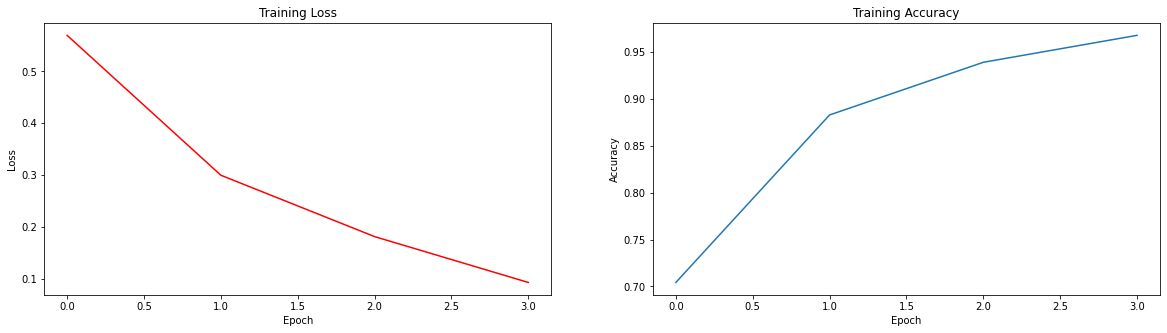

In [63]:
#Plots history of model training
plt.rcParams["figure.figsize"] = (20,5)
fig, axs = plt.subplots(1, 2)

axs[0].plot(history.history['loss'], color='red')
axs[0].set_xlabel('Epoch')
axs[0].set_ylabel('Loss')
axs[0].set_title('Training Loss')

axs[1].plot(history.history['accuracy'])
axs[1].set_xlabel('Epoch')
axs[1].set_ylabel('Accuracy')
axs[1].set_title('Training Accuracy')

plt.show()

In [77]:
New_example = """On the plus side look at the sky last night it was ablaze"""

In [78]:
custom_sequence = tokenizer.texts_to_sequences([New_example])
custom_sequence = pad_sequences(custom_sequence, maxlen=20)

custom_pred = round(model.predict(np.array(custom_sequence))[0][0])
pred = "Not Disaster tweet" if custom_pred == 0 else "Disaster tweet"

print("Tweet:", New_example)
print("Model prediction:", pred)

Tweet: On the plus side look at the sky last night it was ablaze
Model prediction: Not Disaster tweet


# Tfidf Vector and Topic extraction

In [18]:
#define vectorizer parameters
tfidf_vectorizer = TfidfVectorizer(max_df=0.1, max_features=500,
                                  stop_words='english',
                                 use_idf=True,  ngram_range=(1,3))

tfidf_matrix = tfidf_vectorizer.fit_transform(df_train['text_token']) #fit the vectorizer to synopses

print(tfidf_matrix.shape)

(7613, 500)


In [19]:
X = df_train["text_token"]
y = df_train["target"]

In [20]:
X_train,X_test,y_train,y_test = train_test_split(X,y, test_size = 0.30,random_state= 42)

In [21]:
X_train = tfidf_vectorizer.fit_transform(X_train)
X_test = tfidf_vectorizer.fit_transform(X_test)

In [22]:
X_train.toarray()
X_test.toarray()

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [82]:
terms = tfidf_vectorizer.get_feature_names_out()
terms

array(['05', '10', '11', '15', '20', '2015', '201508', '40', '50', '70',
       '70 years', 'accident', 'actually', 'affected', 'air', 'airplane',
       'airport', 'ambulance', 'annihilated', 'anniversary', 'apocalypse',
       'area', 'armageddon', 'army', 'arson', 'ass', 'atomic', 'attack',
       'attacked', 'august', 'away', 'baby', 'bad', 'bag', 'bagging',
       'bags', 'bang', 'battle', 'beautiful', 'believe', 'best', 'better',
       'big', 'bioterror', 'bioterrorism', 'black', 'blast', 'blazing',
       'bleeding', 'blew', 'blood', 'bloody', 'blown', 'boat', 'body',
       'body bag', 'bomb', 'bombed', 'bomber', 'bomber detonated',
       'bomber detonated bomb', 'bombing', 'boy', 'breaking', 'bridge',
       'building', 'buildings', 'burned', 'burning', 'burning buildings',
       'bus', 'bush', 'calgary', 'california', 'california wildfire',
       'came', 'car', 'care', 'casualties', 'casualty', 'catastrophe',
       'catastrophic', 'cause', 'caused', 'change', 'charged', 

In [83]:
#lse model
from sklearn.utils.extmath import randomized_svd
U, Sigma, VT = randomized_svd(tfidf_matrix, n_components=5, n_iter=100,
                              random_state=122)
#printing the concepts
for i, comp in enumerate(VT):
        terms_comp = zip(terms, comp)
        sorted_terms = sorted(terms_comp, key= lambda x:x[1], reverse=True)[:7]
        print("Concept "+str(i)+": ")
        for t in sorted_terms:
            print(t[0])
        print(" ")

Concept 0: 
like
burning
dont
buildings
people
disaster
new
 
Concept 1: 
disaster
nuclear
emergency
obama
new
natural
natural disaster
 
Concept 2: 
burning
buildings
burning buildings
disaster
emergency
nuclear
new
 
Concept 3: 
emergency
new
video
services
storm
plan
news
 
Concept 4: 
emergency
like
plan
services
chemical
burning
buildings
 


# Basic Sentiment Score

In [24]:
from afinn import Afinn
afinn = Afinn()

score = [afinn.score(article) for article in df_train['text_token']]

In [25]:
df_train['sentiment'] = score
df_train

,id,keyword,location,text,target,tokens,text_token,sentiment
0,1,NaN,NaN,Our Deeds are the Reason of this earthquake Ma...,1,"[deeds, reason, earthquake, may, allah, forgiv...",deeds reason earthquake may allah forgive us,1.0
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, , canada]",forest fire near la ronge sask canada,-2.0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,"[residents, asked, , shelter, place, , notifie...",residents asked shelter place notified offic...,-1.0
3,6,NaN,NaN,"13,000 people receive wildfires evacuation ord...",1,"[13000, people, receive, wildfires, evacuation...",13000 people receive wildfires evacuation orde...,-1.0
4,7,NaN,NaN,Just got sent this photo from Ruby Alaska as s...,1,"[got, sent, photo, ruby, alaska, smoke, wildfi...",got sent photo ruby alaska smoke wildfires pou...,0.0
...,...,...,...,...,...,...,...,...
7608,10869,NaN,NaN,wo giant cranes holding a bridge collapse into...,1,"[wo, giant, cranes, holding, bridge, collapse,...",wo giant cranes holding bridge collapse nearby...,-2.0
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1,"[control, wild, fires, california, even, north...",control wild fires california even northern pa...,-2.0
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii.,1,"[m1, , 94, , 0104, utc, , , 5km, volcano, hawa...",m1 94 0104 utc 5km volcano hawaii,0.0
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1,"[police, investigating, ebike, collided, car, ...",police investigating ebike collided car little...,-6.0
